# Модель предсказания результатов экзамена по математике
Данная модель подготовлена в рамках проекта UNICEF, подразделения ООН, задача которого состоит в повышении благополучия детей во всём мире. 

Целью проекта являет разработка модели, предсказывающей результаты экзамена по математике для студентов в возрасте 15-22 лет в зависимости от условий их жизни. 

Для обработки предлагается датасет, содержащий 30 признаков, из которых необходимо отобрать признаки, оказывающие наиболее сильное влияние на итоговую оценку на экзамене. Подробное описание датасета можно найти в файле README.md

![Иллюстрация](pics/school.jpg)

Подготовка модели производилась следующим образом

### Загрузка необходимых для работы библиотек

In [60]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок


### Загрузка, обзор и преобразование данных
Данные представлены в виде одного датасета, содержащего 29 признаков и собственно результаты экзамена. 
Загрузим датасет и проведём первичный обзор данных

In [2]:
stud = pd.read_csv('stud_math.csv')
display(stud.head())
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Переименуем столбцы для придания данным единообразия, а также для того, чтобы содержание столбца было понятно из названия.

In [3]:
stud.columns = ['school', 'sex', 'age', 'address', 'fam_size', 'parents_status', 'mother_edu', 'father_edu',
                'mother_job', 'father_job', 'reason', 'guardian', 'travel_time', 'study_time', 'failures',
                'school_support', 'fam_support', 'paid', 'activities', 'nursery', 'study_time_g', 'higher', 'internet', 'romantic',
                'fam_relations', 'free_time', 'go_out', 'health', 'absences', 'score']

Из предварительного обзора видно, что данные содержат пропуски. Оценим процент пустых данных в каждом столбце и , исходя из этого, примем решение, каким образом их заполнять. Для этого напишем функцию расчёта отсутствующих величин по колонкам

In [4]:
def missing_values_table(df):
        # Всего пустых позиций
        mis_val = df.isnull().sum()
        
        # Процент пустых позиций
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Таблица с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименование колонок в таблице
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировка таблицы по убыванию % отсутствующих данных
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Итоговая информация в виде текста
        print ("В изучаемом датасете " + str(df.shape[1]) + " столбцов.\n"      
            "Всего " + str(mis_val_table_ren_columns.shape[0]) +
              " столбцов содержат отсутствующие значения.")
        
        # Таблица с результатами
        return mis_val_table_ren_columns

In [5]:
missing_values_table(stud)

В изучаемом датасете 30 столбцов.
Всего 27 столбцов содержат отсутствующие значения.


,Missing Values,% of Total Values
parents_status,45,11.4
paid,40,10.1
fam_support,39,9.9
father_job,36,9.1
internet,34,8.6
romantic,31,7.8
guardian,31,7.8
travel_time,28,7.1
fam_relations,27,6.8
fam_size,27,6.8


Как следует из таблицы, количество отсутствующих значений не превышает 12%. Поэтому представляется вполне допустимым заполнить пустоты модой: наиболее часто встречающимися значениями. Исключения составляют 4 столбца. В столбцах score и absences логично заменить отсутствующие значения на 0.0, т.к. оценки за экзамен нет, занятия ученик вероятно не пропускал. Что касается столбцов parents_status и fam_size, то здесь пропуски будут заполнятся в зависимости от взаимных значений данных столбцов. Подробные пояснения ниже. 

Из обзора данных, а также описания датасета следует, что в датасете присутствуют числовые, категориальные и бинарные столбцы. Специфика изучаемого датасета в том, что некоторые данные, представленные в числовом виде, на самом деле являются категориальными. 

Для удобства дальнейшей работы составим списки наименований колонок, разделив их на числовые и категориальные.

In [33]:
# Временно не будем добавлять в список позиции 'fam_size', 'parents_status', они будут добавлены позднее
list_cat = ['school', 'sex', 'address',  'mother_edu', 'father_edu',
                'mother_job', 'father_job', 'reason', 'guardian', 'travel_time', 'study_time', 'failures',
                'school_support', 'fam_support', 'paid', 'activities', 'nursery', 'study_time_g', 'higher', 'internet', 'romantic',
                'fam_relations', 'free_time', 'go_out', 'health']

list_num = ['age', 'absences', 'score']


### Приведение в порядок категориальных переменных
Напишем функцию, которая заменить отсутствующие данные на моду, преобразует данные в строковые, покажет  распределение признаков в формате таблицы и выведет информацию по каждой колонке для проверки результатов преобразования. 

In [12]:
def prepare_category(column):
    stud[column].fillna(stud[column].mode()[0], inplace=True)
    stud[col] = stud[col].astype(str)
    display(pd.DataFrame(stud[column].value_counts()))
    stud.loc[:,[column]].info()

In [13]:
for col in list_cat:
    prepare_category(col)

,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,address
U,312
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,mother_edu
4.0,134
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mother_edu  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,father_edu
2.0,130
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   father_edu  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,mother_job
other,152
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mother_job  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,father_job
other,233
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   father_job  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,reason
course,154
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,guardian
mother,281
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,travel_time
1.0,270
2.0,96
3.0,22
4.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   travel_time  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,study_time
2.0,201
1.0,103
3.0,64
4.0,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   study_time  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,failures
0.0,315
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   failures  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,school_support
no,344
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   school_support  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,fam_support
yes,258
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fam_support  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,paid
no,240
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,activities
yes,209
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,nursery
yes,316
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,study_time_g
-6.0,201
-3.0,103
-9.0,64
-12.0,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   study_time_g  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,higher
yes,376
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,internet
yes,339
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,romantic
no,271
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,fam_relations
4.0,209
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fam_relations  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,free_time
3.0,164
4.0,112
2.0,63
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   free_time  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,go_out
3.0,135
2.0,101
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   go_out  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,health
5.0,153
3.0,89
4.0,63
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   health  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Как мы видим в полученных таблицах, преобразования и замены прошли успешно: в столбцах не осталось пропущенных данных, числовые данные приведены к формату категорий. Также можно заметить явную ошибку в столбце fam_relations - в предложенных к выбору данных не было отрицательных значений. Поэтому значение -1 смело можно заменить на 1. То же касается столбца father_edu - значение 40.0 является явной опечаткой и может быть заменено на 4.0. Столбец study_time_g содержит только отрицательные значения, не имеет описательного смысла и может быть удалён. Проделаем эти манипуляции и проверим результат.

In [20]:
stud.loc[(stud['father_edu'] == '40.0'), 'father_edu'] = '4.0'
stud.loc[(stud['fam_relations'] == '-1.0'), 'fam_relations'] = '1.0'
stud['father_edu'].value_counts()

2.0    130
3.0     96
4.0     89
1.0     78
0.0      2
Name: father_edu, dtype: int64

In [19]:
stud['fam_relations'].value_counts()

4.0    209
5.0     99
3.0     62
2.0     17
1.0      8
Name: fam_relations, dtype: int64

In [21]:
stud.drop(['study_time_g'], inplace = True, axis = 1)

Ошибки исправлены. 

Теперь заполним пробелы в столбцах fam_size и parents_status. Замена будет производится по следующей логике: если размер семьи больше трёх человек, то вероятнее всего родители живут вместе: мать-одиночка с тремя детьми скорее редкость. Если размер семьи менее трёх человек или не указан, то вероятнее всего родители проживают отдельно. Затем заполним оставшиеся пустоты в столбце fam_size: если родители живут раздельно, то размер семьи вероятнее всего менее трёх человек.

In [22]:
mask = (stud['fam_size'] =='GT3')&(stud['parents_status'].isna())
stud.loc[mask, 'parents_status'] = 'T'
mask = (stud['fam_size'] =='LE3')&(stud['parents_status'].isna())
stud.loc[mask, 'parents_status'] = 'A'
mask = (stud['fam_size'].isna())&(stud['parents_status'].isna())
stud.loc[mask, 'parents_status'] = 'A'

In [23]:
mask = (stud['parents_status'] == 'A')&(stud['fam_size'].isna())
stud.loc[mask, 'fam_size'] = 'LE3'

Проверим результат обработки.

In [25]:
display(pd.DataFrame(stud['parents_status'].value_counts()))
stud.loc[:,['parents_status']].info()

,parents_status
T,342
A,53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   parents_status  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [26]:
display(pd.DataFrame(stud['fam_size'].value_counts()))
stud.loc[:,['fam_size']].info()

,fam_size
GT3,261
LE3,114


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fam_size  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Теперь в столбцах полные данные.

Скорректируем список категориальных колонок: добавим обработанные столбцы fam_size и parents_status, а также удалим наименование удалённого столбца study_time_g

In [34]:
list_cat.append('fam_size')
list_cat.append('parents_status')
list_cat.remove('study_time_g')

### Приведение в порядок числовых переменных
Напишем функцию, которая заменит отсутствующие данные на 0.0. Для колонок score и absences это логичная замена, а в столбце age пропусков нет.

In [36]:
def prepare_num_null(column):
    stud[column].fillna(0, inplace=True)
    display(pd.DataFrame(stud[column].value_counts()))
    return stud.loc[:,[column]].info()

In [37]:
for col in list_num:
    prepare_num_null(col)

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


,absences
0.0,123
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  395 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


,score
50.0,54
55.0,46
0.0,43
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   395 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Преобразование данных завершено. 

### Проверка числовых столбцов 
Изучим распределение данных и отфильтруем выбросы.

Изучим столбец *absences*

count    395.000000
mean       7.058228
std       23.138935
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

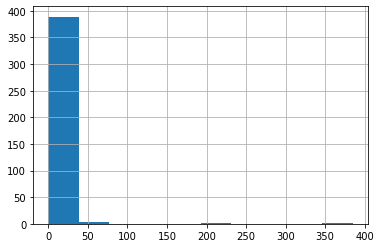

In [39]:
stud.absences.hist()
stud.absences.describe()

Медианным значением является 4 пропущенных занятия,  максимальным - 385. Это невозможно даже в связи с тем что в году всего 365 дней. Но есть и другие значения, явно попадающие в категорию выбросов. Определим их и отфильтруем. Для этого напишем функцию.

In [66]:
def statistic(column):
    median = stud[column].median()
    IQR = stud[column].quantile(0.75) - stud[column].quantile(0.25)
    perc25 = stud[column].quantile(0.25)
    perc75 = stud[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    stud[column].loc[stud[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, label = 'IQR')
    plt.legend()

25-й перцентиль: 0.0, 75-й перцентиль: 6.25, IQR: 6.25,  Границы выбросов: [-9.375, 15.625].


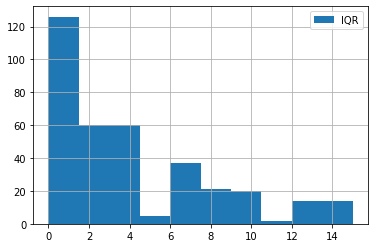

In [67]:
statistic('absences')

In [42]:
stud = stud.loc[stud['absences'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 394
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   school          378 non-null    object 
 1   sex             378 non-null    object 
 2   age             378 non-null    int64  
 3   address         378 non-null    object 
 4   fam_size        358 non-null    object 
 5   parents_status  378 non-null    object 
 6   mother_edu      378 non-null    object 
 7   father_edu      378 non-null    object 
 8   mother_job      378 non-null    object 
 9   father_job      378 non-null    object 
 10  reason          378 non-null    object 
 11  guardian        378 non-null    object 
 12  travel_time     378 non-null    object 
 13  study_time      378 non-null    object 
 14  failures        378 non-null    object 
 15  school_support  378 non-null    object 
 16  fam_support     378 non-null    object 
 17  paid            378 non-null    obj

Теперь датасет отфильтрован на выброс по столбцу *absences*.
Посмотрим столбец *age*

count    378.000000
mean      16.664021
std        1.266096
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

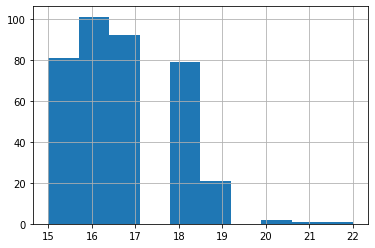

In [43]:
stud.age.hist()
stud.age.describe()

Основная масса учащихся находится в возрасте от 16 до 18 лет,  медианный возраст - 17 лет. Возраст от 20 до 22 вероятнее всего является выбросом. Проверим и отфильтруем.

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


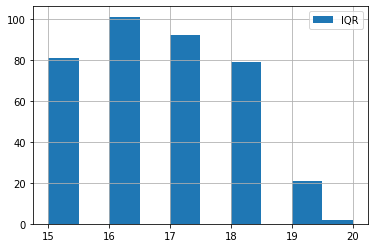

In [68]:
statistic('age')

In [47]:
stud = stud.loc[stud['age'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 394
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   school          376 non-null    object 
 1   sex             376 non-null    object 
 2   age             376 non-null    int64  
 3   address         376 non-null    object 
 4   fam_size        356 non-null    object 
 5   parents_status  376 non-null    object 
 6   mother_edu      376 non-null    object 
 7   father_edu      376 non-null    object 
 8   mother_job      376 non-null    object 
 9   father_job      376 non-null    object 
 10  reason          376 non-null    object 
 11  guardian        376 non-null    object 
 12  travel_time     376 non-null    object 
 13  study_time      376 non-null    object 
 14  failures        376 non-null    object 
 15  school_support  376 non-null    object 
 16  fam_support     376 non-null    object 
 17  paid            376 non-null    obj

Рассмотрим столбец  *score*. Его мы не будем чистить от выбросов.

count    376.000000
mean      51.476064
std       23.844261
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

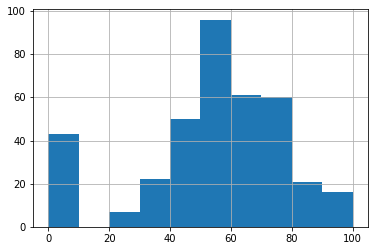

In [70]:
stud.score.hist()
stud.score.describe()

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


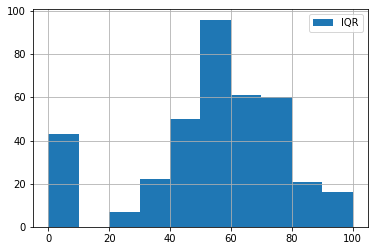

In [69]:
statistic('score')

# Рассмотрим зависимости между переменными
## Проведём корреляционный анализ числовых переменных
Составим график jointplot и таблицу корреляций.

In [62]:
def jointplot_stud(column1, column2):
    return sns.jointplot(x = column1, y = column2, data = stud)

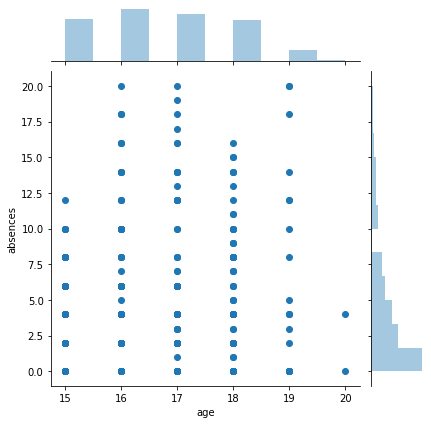

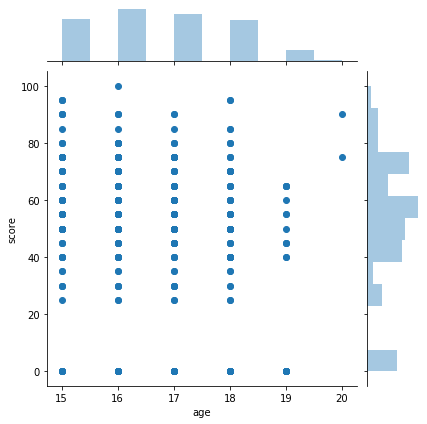

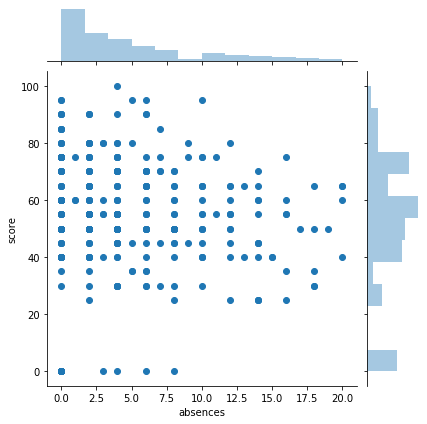

In [63]:
pairs = list(itertools.combinations(list_num,2))
for pair in pairs:
    jointplot_stud(pair[0], pair[1])

По графикам явной корреляции не прослеживается.

In [50]:
stud.corr()

,age,absences,score
age,1.000000,0.123697,-0.191752
absences,0.123697,1.000000,0.076372
score,-0.191752,0.076372,1.000000


Как можно видеть в таблице, переменных, имеющих между собой корреляцию хотя бы более 60% нет. Поэтому удалять столбцы мы не будем.
Возраст явно оказывает значительное негативное влияние на оценки.
Неожиданной оказалась положительная корреляция между количеством пропусков и оценками.

## Анализ номинативных переменных
Напишем функцию построения графиков вида boxplot для категориальных и бинарных переменных.

In [51]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud.loc[stud.loc[:, column].isin(stud.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

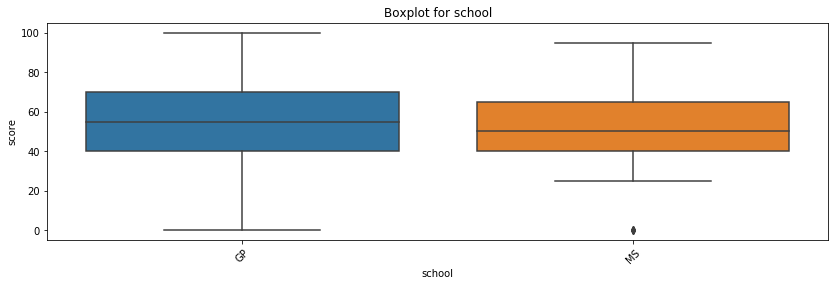

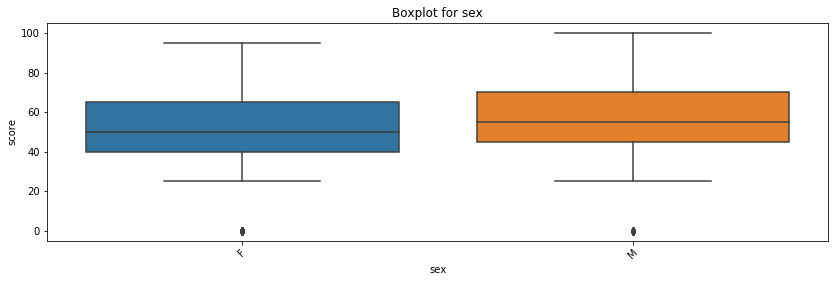

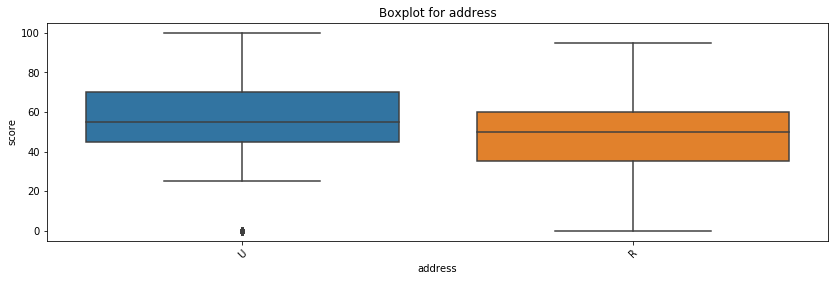

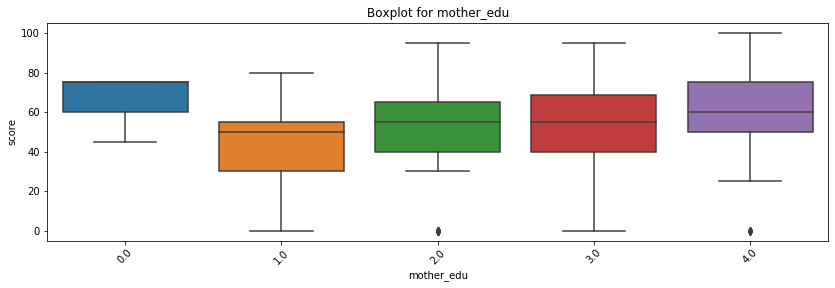

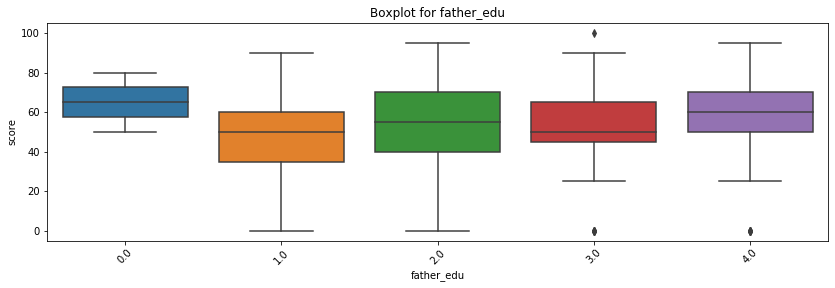

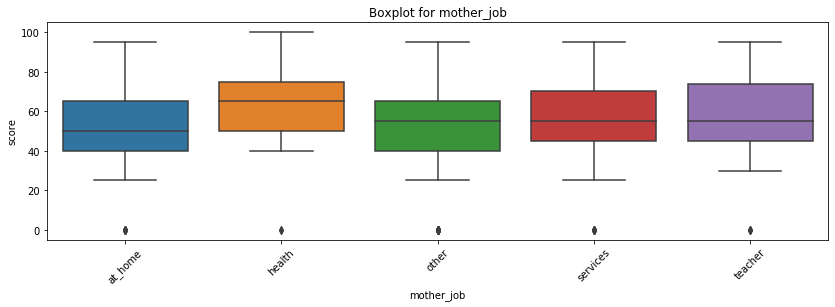

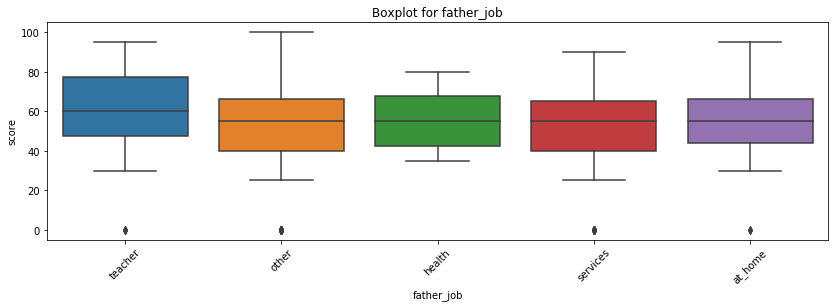

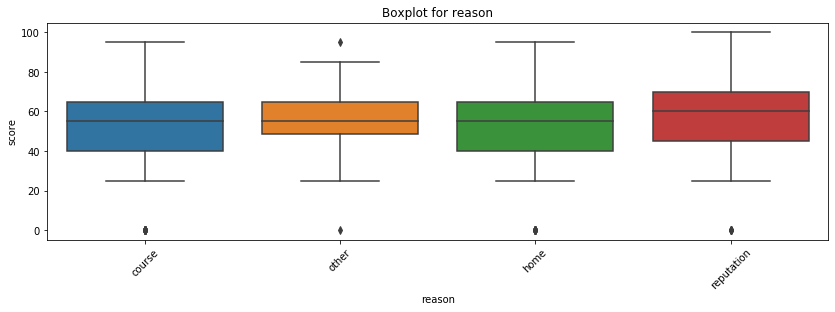

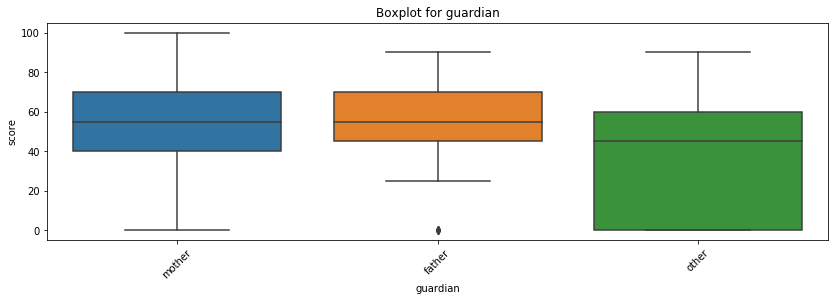

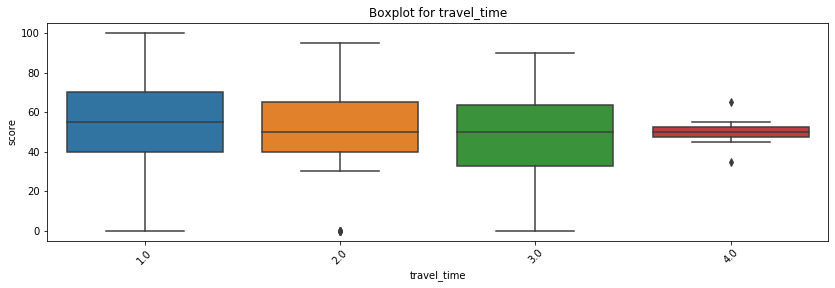

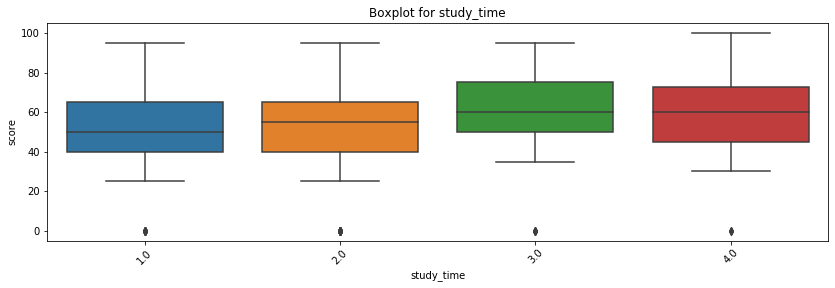

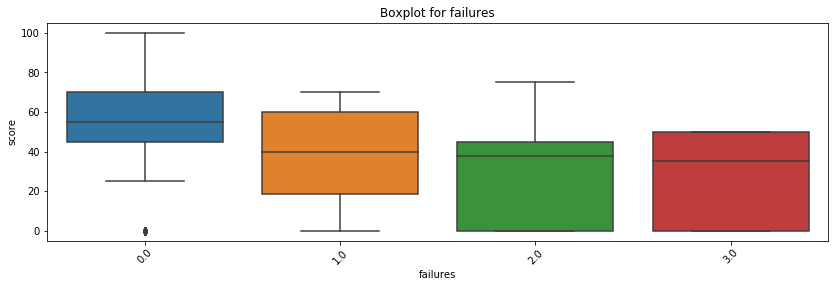

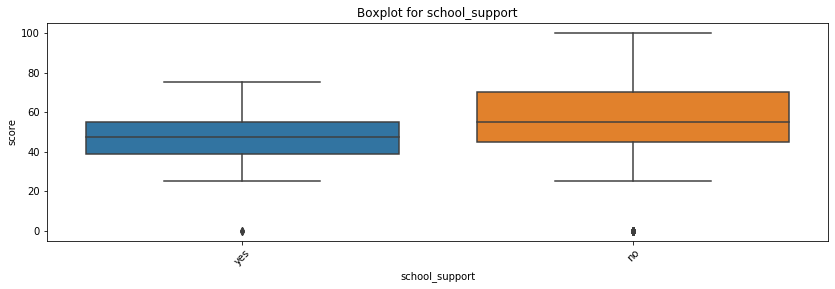

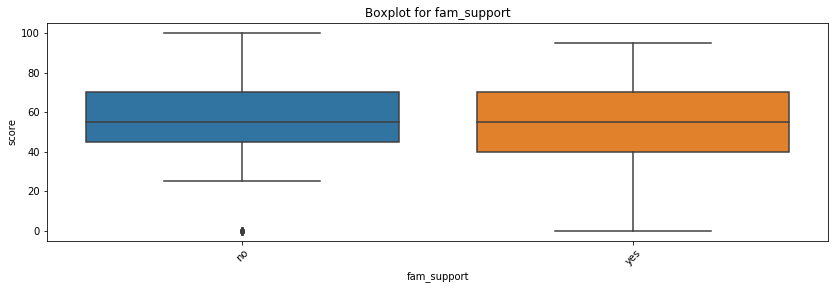

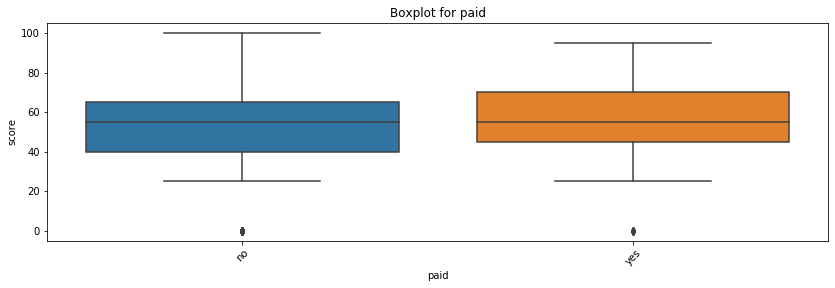

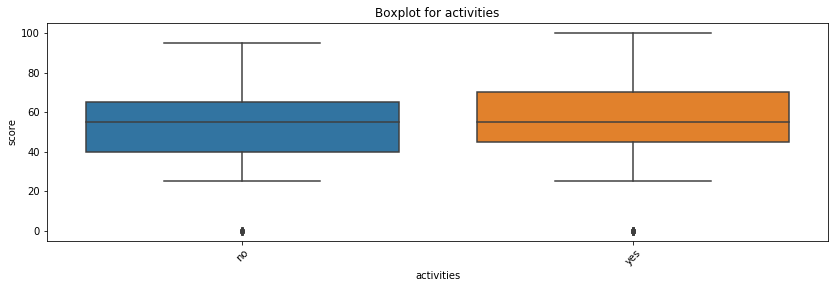

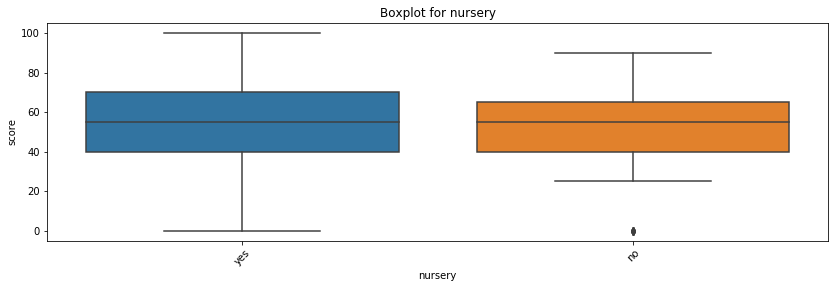

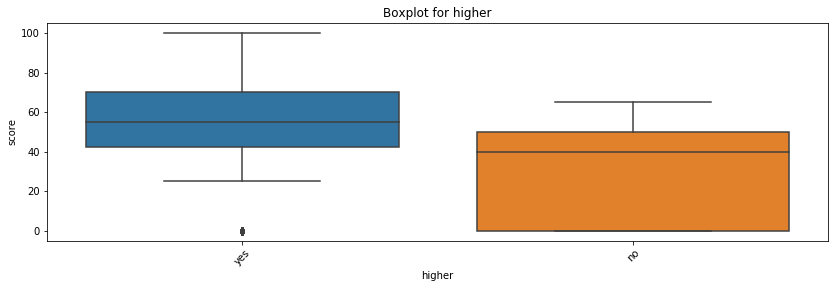

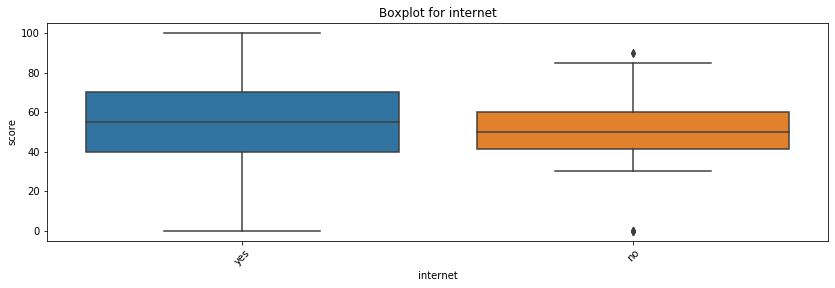

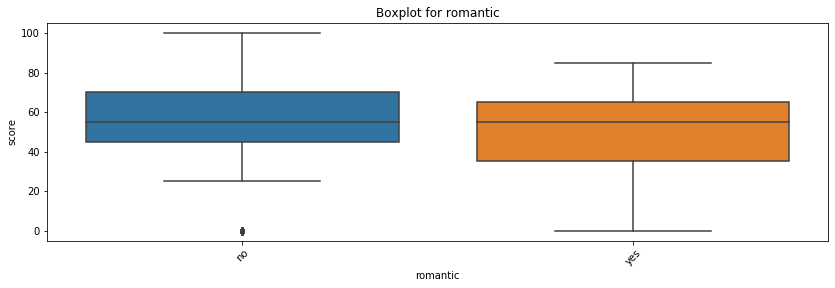

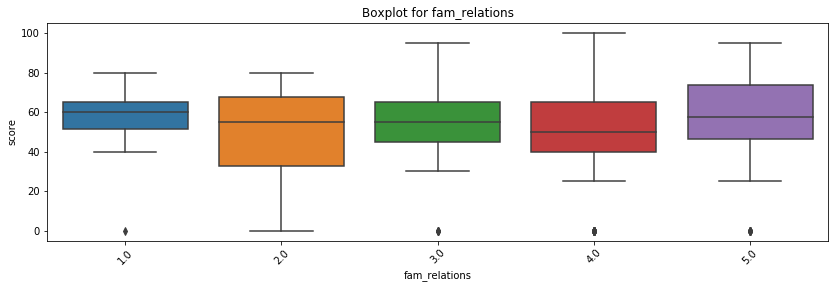

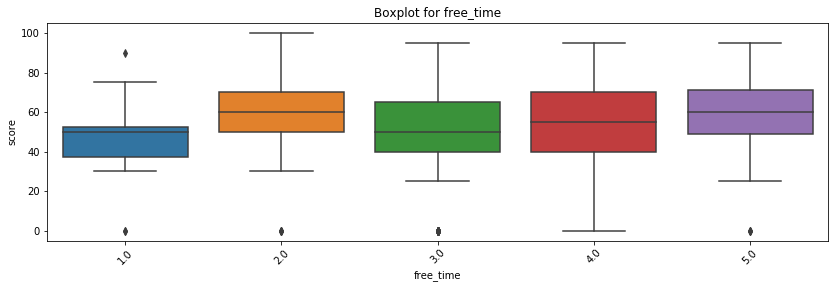

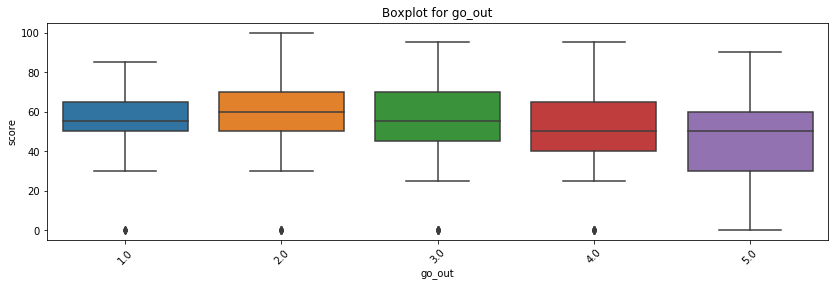

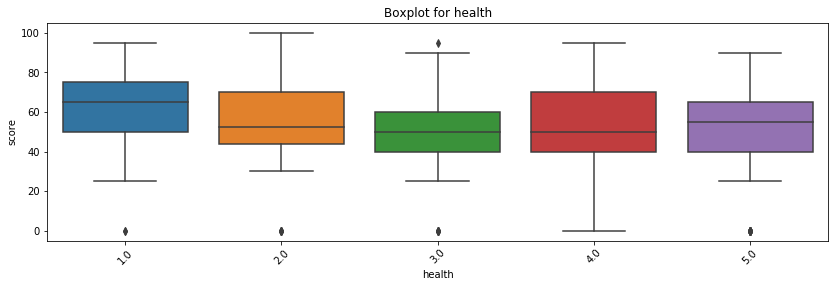

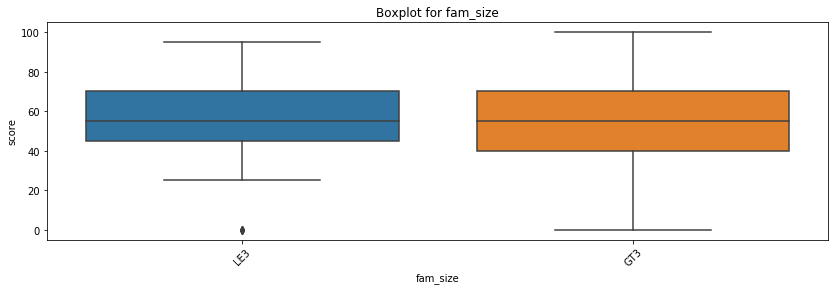

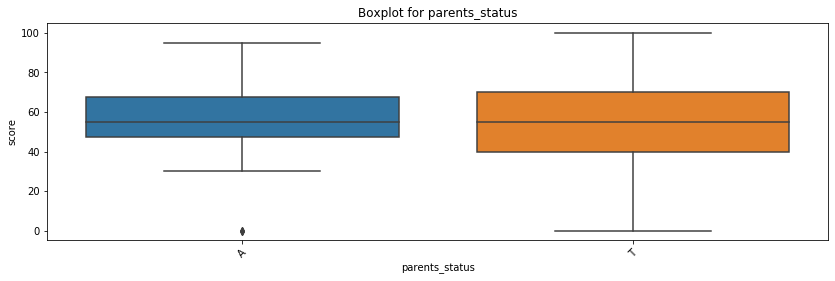

In [52]:
for col in list_cat:
    get_boxplot(col)

Можно заметить, что некоторые категории, например, должность отца или время в пути до школы не сильно различаются по влиянию на результат экзамена. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью **теста Стьюдента**. Проверим нулевую гипотезу о том, что распределения оценок экзамен по различным параметрам неразличимы.

Напишем функцию и проверим результат.

In [57]:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                        stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


In [61]:
for col in list_cat:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки mother_edu
Найдены статистически значимые различия для колонки father_edu
Найдены статистически значимые различия для колонки mother_job
Найдены статистически значимые различия для колонки guardian
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки school_support
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки health


Таким образом, реальное влияние на итоги экзаменов (*score*) оказывают следующие столбцы:
1. Числовые  
    возраст (*age*), количество пропусков (*absences*)
2. Категориальные 
пол (*sex*),образование обоих родителей (*mother_edu, father_edu*), работа матери (*mother_job*), опекун (*guardian*), провалы (*failures*), поддержка в школе (*school_support*), платная подготовка (*paid*), планы на высшее образование (*higher*), наличие отношений (*romantic*) и здоровье (*health*). 
  
Создадим итоговый датасет , содержащий только релевантные столбцы.

In [64]:
stud_for_model = stud.loc[:, ['score', 'age', 'absences', 'sex', 'mother_edu', 'father_edu', 
                              'mother_job', 'guardian', 'failures', 'school_support', 'paid', 'higher', 'romantic', 
                              'health']]

In [65]:
stud_for_model.head()

,score,age,absences,sex,mother_edu,father_edu,mother_job,guardian,failures,school_support,paid,higher,romantic,health
0,30.0,18,6.0,F,4.0,4.0,at_home,mother,0.0,yes,no,yes,no,3.0
1,30.0,17,4.0,F,1.0,1.0,at_home,father,0.0,no,no,yes,no,3.0
2,50.0,15,10.0,F,1.0,1.0,at_home,mother,3.0,yes,no,yes,no,3.0
3,75.0,15,2.0,F,4.0,2.0,health,mother,0.0,no,yes,yes,yes,5.0
4,50.0,16,4.0,F,3.0,3.0,other,father,0.0,no,yes,yes,no,5.0


# Выводы
- В данных не более 12% пропусков, большая часть которых была замещена наиболее часто встречающимися параметрами. В случае с размером семьи (*fam_size*) и статусом проживания родителей (*parents_status*) было решено заполнять статус проживания родителей (вместе или раздельно) в зависимости от размера семьи. Оценки (*score*) и пропущенные занятия (*absences*)заполнялись нулями, т.к. это наиболее очевидная альтернатива в случае отсутствия данных.

- Ошибки в категориальных данных были исправлены вручную.В данных по отсутствию на занятиях (*absences*) содержались ошибки и выбросы, которые были исправлены. Также выбросы были устранены по столбцу возраст (*age*). 

- Несомненное влияние на оценки оказывает возраст учеников (*age*) и пропуски занятий (*absences*)

- Из категориальных переменных в модель выбраны параметры: пол (sex),образование обоих родителей (mother_edu, father_edu), работа матери (mother_job), опекун (guardian), провалы (failures), поддержка в школе (school_support), платная подготовка (paid), планы на высшее образование (higher), наличие отношений (romantic) и здоровье (health).